

<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 What is Quora? </h2>


<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.</p>


Credits: Kaggle

<h2> 1.2 Problem Statement </h2>


- We are tasked to identify whether a asked question is having similar question with the same intent.
- Advantage with this is that the posted question can be instantly answered.

<h2> 1.3 Question Source</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs

<h2>1.4 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification is high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No latency concerns.
4. Interpretability is partially important as it may help if they use manual merging below threshold.

<h1> 2.Machine Learning Problem </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

- Data will be in a csv file
- Data contains 5 columns : qid1, qid2, question1, question2, is_duplicate
- Size of data - 60MB
- Number of rows in data = 404,290

<h3> 2.1.2 Example Data points </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>


<h3> 2.2.1 Machine Learning Problem </h3>


<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Evaluation metrics </h3>



- Log Loss
- Binary Confusion Matrix

<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Importing all the required libraries </h2>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import distance
from nltk.stem import SnowballStemmer 
from fuzzywuzzy import fuzz
from wordcloud import WordCloud
import os

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91984\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<h2> 3.2 Reading Data into Dataframe </h2>

In [2]:
df = pd.read_csv(r"C:\Users\91984\Downloads\train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df[df['qid1'] == 1]

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


Given data fields are consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>

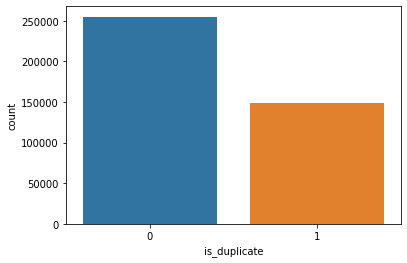

In [6]:
ax = sns.countplot(x="is_duplicate", data=df)

In [7]:
print(' Total no of question pairs for training:\n  {}'.format(len(df)))

 Total no of question pairs for training:
  404290


In [8]:
print('Question pairs which are not similar {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('Question pairs which are similar {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

Question pairs which are not similar 63.08%
Question pairs which are similar 36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [9]:
quesids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_ques = len(np.unique(quesids))
multi_ques = np.sum(quesids.value_counts() > 1)
print ('Total number of Unique Questions are: {}\n'.format(unique_ques))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} \n'.format(multi_ques))

print ('Percentage of questions that appear more than one time: {}% \n'.format(multi_ques/unique_ques*100))

print ('Maximum number of times a single question is repeated: {}\n'.format(max(quesids.value_counts()))) 

q_vals=quesids.value_counts()

q_vals=q_vals.values

Total number of Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 

Percentage of questions that appear more than one time: 20.77953945937505% 

Maximum number of times a single question is repeated: 157



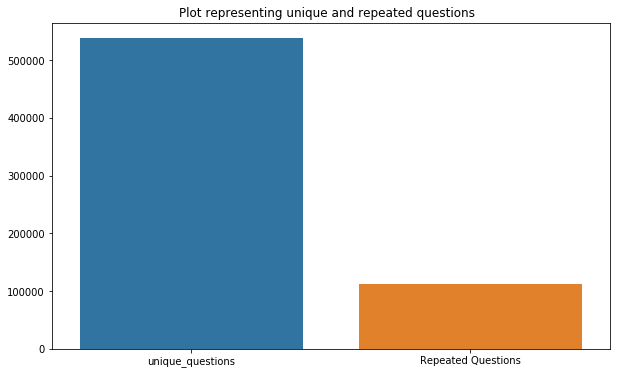

In [10]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_ques , multi_ques]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3> 3.2.3 Checking for Duplicates </h3>

In [11]:
#checking whether there are any repeated pair of questions

duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

In [12]:
print ("Number of duplicate questions",duplicates.shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>


Text(0, 0.5, 'Number of such questions')

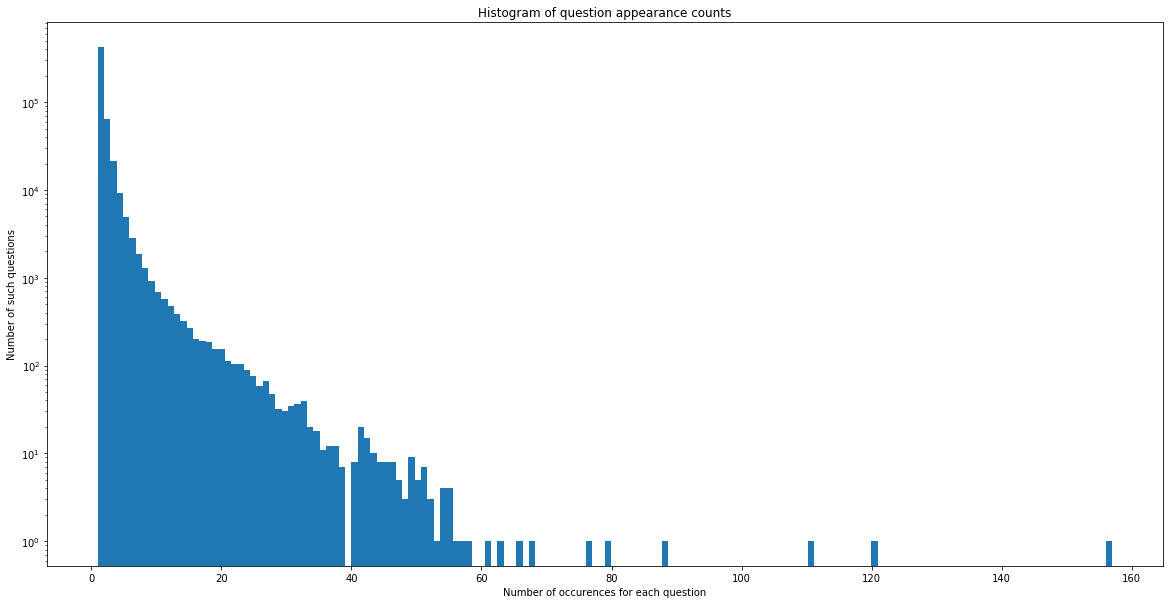

In [13]:
plt.figure(figsize=(20, 10))

plt.hist(quesids.value_counts(),bins= 160)

plt.yscale('log')

plt.title('Histogram of question appearance counts')

plt.xlabel('Number of occurences for each question')

plt.ylabel('Number of such questions')


<h3> 3.2.5 Checking for NULL values </h3>

- we can already see from df.info there are some columns with null values

In [14]:
#Displaying rows with null values

#axis equals to 1 signifies rows wise isnull
nan_rows = df[df.isnull().any(axis=1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [15]:
#correcting those null values
df.fillna('',inplace = True)


In [16]:
#Displaying any rows after correcting with null values

nan_rows = df[df.isnull().any(axis=1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2> 3.3 Feature Extraction </h2>

- <b> freq_q1 </b> : frequency of question 1's
- <b> freq_q2 </b> : frequency of question 2's

*the reason we use transform('count') instaed of .count() is that transform produces dataframe with rows equal to the original dataframe*

In [17]:
df['freq_q1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_q2'] = df.groupby('qid2')['qid2'].transform('count')

- <b> len_q1 </b> : length of question 1's
- <b> len_q2 </b> : length of question 2's

In [18]:
df['len_q1'] = df['question1'].str.len()
df['len_q2'] = df['question2'].str.len()

- <b> words_q1 </b> : words in question 1's
- <b> words_q2 </b> : words in question 2's

In [19]:
df['words_q1'] = df['question1'].apply(lambda question : len(question.split(" ")))
df['words_q2'] = df['question2'].apply(lambda question : len(question.split(" ")))

In [20]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_q1,freq_q2,len_q1,len_q2,words_q1,words_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7


- <b> common_words </b> : common words in both the questions


In [21]:
#we have to mention axis as default value is 0( along the column)
def func_common(row):
    words1 = set(map((lambda word : word.lower().strip()), row['question1'].split(" ")))
    words2 = set(map((lambda word : word.lower().strip()), row['question2'].split(" ")))
    return len(words1 & words2)

df['common_words'] = df.apply(func_common,axis = 1) 


- <b> total_words </b> : total words in both the questions


In [22]:
def func_total(row):
    words1 = set(map((lambda word : word.lower().strip()), row['question1'].split(" ")))
    words2 = set(map((lambda word : word.lower().strip()), row['question2'].split(" ")))
    return len(words1) + len(words2)

df['total_words'] = df.apply(func_total,axis = 1) 

- <b> share_words </b> : common percent among the total words

In [23]:
def func_share(row):
    words1 = set(map((lambda word : word.lower().strip()), row['question1'].split(" ")))
    words2 = set(map((lambda word : word.lower().strip()), row['question2'].split(" ")))
    return float(len(words1 & words2))/(len(words1) + len(words2))

df['share_words'] = df.apply(func_share,axis = 1) 

- <b> sum_freq </b> : sum of frequency of questions
- <b> diff_freq </b> : difference of frequency of questions

In [24]:
df['sum_freq'] = df['freq_q1']+df['freq_q2']
df['diff_freq'] = abs(df['freq_q1']-df['freq_q2'])

In [25]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_q1,freq_q2,len_q1,len_q2,words_q1,words_q2,common_words,total_words,share_words,sum_freq,diff_freq
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000,4,2


<h3> 3.3.1 Analysis of features </h3>


<h4> 3.3.1.1 common_words feature </h4>

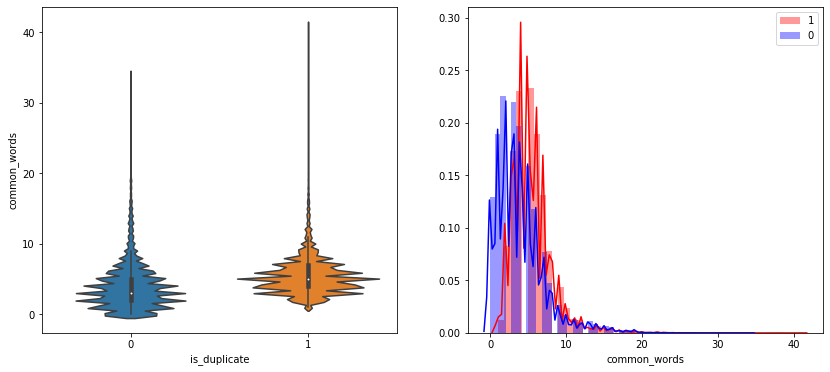

In [26]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.violinplot(x = "is_duplicate",y = "common_words",data = df)

plt.subplot(1,2,2)
sns.distplot(df[df["is_duplicate"] == 1]["common_words"],color = "r",label="1")
sns.distplot(df[df["is_duplicate"] == 0]["common_words"],color = "b",label="0")
plt.legend()
plt.show()



- Here there is lot of overlap between duplicate and non-duplicate questions.

<h4> 3.3.1.2 share_words feature </h4>

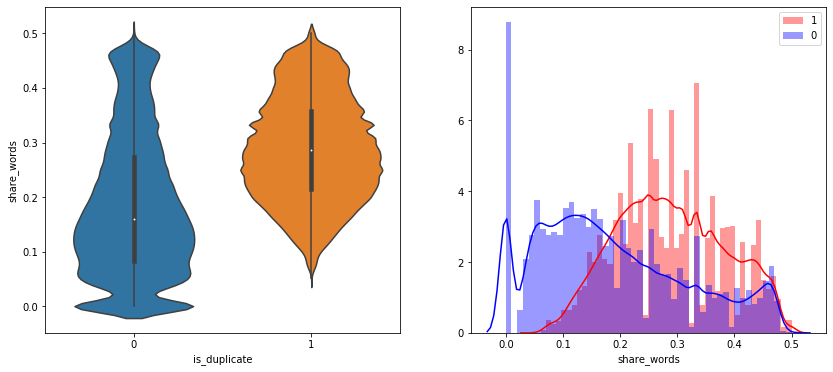

In [27]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.violinplot(x = "is_duplicate",y = "share_words",data = df)

plt.subplot(1,2,2)
sns.distplot(df[df["is_duplicate"] == 1]["share_words"],color = "r",label="1")
sns.distplot(df[df["is_duplicate"] == 0]["share_words"],color = "b",label="0")
plt.legend()
plt.show()



- we observe that the overlap in the far-left is minimal, hence may prove a very decisive feature.
- there is very high overlap on far-right in distribution plot.
- when the share_words is more then it is more likely to be a similar question.

<h2> 3.4 Text Preprocessing</h2>

- **Different steps involved**:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions

In [12]:
STOP_WORDS = stopwords.words("english")

In [33]:


def preprocess(x):
    x = str(x).lower() 
    
    #expanding contractions, this can also be done using some dictionary of contradictions  as keys or using contracdictions.fix()
    
    
    x = x.replace(",000,000", "m").replace(",000", "k") \
         .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
         .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
         .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
         .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
         .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
         .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    snow = SnowballStemmer(language='english')
    pattern = re.compile('\W')
    
    #removing punctuations
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
        
    #removing html tags using beautiful soup and stemming using snowball stemmer
    
    if type(x) == type(''):
        x = " ".join(snow.stem(i) for i in x.split())
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

<h2> 3.5 Additional Feature Extraction </h2>

- Explaing some terms that will be used:
    - __token__: the parts you get by splitiing a sentence
    - <b>stop words</b>: words which do not have any sematic meaning
    - <b>words</b>: collection of tokens excluding stop words

Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>
- __longest_substr_ratio__ : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
    longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

<h3> Fuzzy Features</h3>

> __Introduction To Fuzzy Features__:
 https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
 
1. __ratio__ 
2. __partial_ratio__  
3. __token_sort_ratio__ 
4. __token_set_ratio__ 
5. __partial_token_sort_ratio__
6. __partial_token_set_ratio__
7. __WRatio__


In [34]:
SAFE_DIV=0.0001

def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   


    

In [40]:
def extract_features2(df):
    
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["partial_token_sort_ratio"]   = df.apply(lambda x: fuzz.partial_token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["partial_token_set_ratio"]    = df.apply(lambda x: fuzz.partial_token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["WRatio"]    = df.apply(lambda x: fuzz.WRatio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)

In [41]:
extract_features2(df)

In [42]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_q1,freq_q2,len_q1,len_q2,...,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,ratio,partial_ratio,partial_token_sort_ratio,partial_token_set_ratio,WRatio,longest_substr_ratio
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,1,1,66,57,...,2.0,13.0,100,92,92,100,87,100,95,0.982143
1,1,3,4,what is the stori of kohinoor koh i noor diamond,what would happen if the indian govern stole t...,0,4,1,51,88,...,5.0,12.5,86,65,67,71,73,100,86,0.571429
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0,1,1,73,59,...,4.0,12.0,72,64,39,38,70,100,68,0.185185
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math 23 24 math is divid...,0,1,1,50,65,...,2.0,12.0,31,27,22,27,33,36,29,0.045455
4,4,9,10,which one dissolv in water quik sugar salt met...,which fish would surviv in salt water,0,3,1,76,39,...,6.0,10.0,68,50,36,54,72,100,86,0.157895


In [43]:
#df.to_csv("nlp_feat_train.csv", index=False)

<h3>3.5.1 Analysis of extracted features </h3>

<h3> 3.5.1.1 Plotting Word clouds</h3>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [3]:
df = pd.read_csv("nlp_feat_train.csv",encoding='utf-8')
df.fillna('')

,id,qid1,qid2,question1,question2,is_duplicate,freq_q1,freq_q2,len_q1,len_q2,...,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,ratio,partial_ratio,partial_token_sort_ratio,partial_token_set_ratio,WRatio,longest_substr_ratio
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,1,1,66,57,...,2.0,13.0,100,92,92,100,87,100,95,0.982143
1,1,3,4,what is the stori of kohinoor koh i noor diamond,what would happen if the indian govern stole t...,0,4,1,51,88,...,5.0,12.5,86,65,67,71,73,100,86,0.571429
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0,1,1,73,59,...,4.0,12.0,72,64,39,38,70,100,68,0.185185
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math 23 24 math is divid...,0,1,1,50,65,...,2.0,12.0,31,27,22,27,33,36,29,0.045455
4,4,9,10,which one dissolv in water quik sugar salt met...,which fish would surviv in salt water,0,3,1,76,39,...,6.0,10.0,68,50,36,54,72,100,86,0.157895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,how mani keyword are there in the racket progr...,how mani keyword are there in perl program lan...,0,2,2,85,79,...,1.0,13.5,96,87,91,86,82,100,91,0.410959
404286,404286,18840,155606,do you believ there is life after death,is it true that there is life after death,1,12,1,41,42,...,1.0,8.5,79,70,72,76,69,100,75,0.650000
404287,404287,537928,537929,what is one coin,what is this coin,0,1,1,17,17,...,0.0,4.0,86,79,79,75,75,100,82,0.470588
404288,404288,537930,537931,what is the approx annual cost of live while s...,i am have littl hairfal problem but i want to ...,0,1,1,94,127,...,8.0,21.0,36,34,32,36,33,100,34,0.056818


In [4]:
df_dup = df[df['is_duplicate'] == 1]
df_non = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_dup["question1"], df_dup["question2"]]).flatten()
n = np.dstack([df_non["question1"], df_non["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p)//2)
print ("Number of data points in class 0 (non duplicate pairs) :",len(n)//2)



Number of data points in class 1 (duplicate pairs) : 149263
Number of data points in class 0 (non duplicate pairs) : 255027


In [6]:
#Saving the np array into a text file
import io
with io.open("train_pos.txt", "w+", encoding="utf-8") as f:
    for i in range(len(p)):
        f.write(p[i])
        f.write(" ")

In [7]:
with io.open("train_neg.txt", "w+", encoding="utf-8") as f:
    for i in range(len(n)):       
        f.write(str(n[i]))
        f.write(" ")# to give space between two sentences

In [19]:
# reading the text files and removing the Stop Words:

f1 = open(r"C:\Users\91984\Downloads\train_pos.txt",encoding="utf-8")
text_pw = f1.read()

f2 = open(r"C:\Users\91984\Downloads\train_neg.txt",encoding="utf-8")
text_nw = f2.read()

stop_words = set(STOP_WORDS)
stop_words.add("said")
stop_words.add("br")
stop_words.add(" ")

stop_words.remove("not")
stop_words.remove("no")

print("Total number of words in duplicate pair questions :",len(text_pw))
print("Total number of words in non duplicate pair questions :",len(text_nw))

Total number of words in duplicate pair questions : 14640867
Total number of words in non duplicate pair questions : 30064858


 <h3>Word Clouds generated from  duplicate pair question's text</h3>

Word Cloud for Duplicate Question pairs


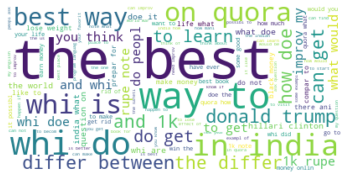

In [20]:
wc = WordCloud(background_color="white", max_words=len(text_pw), stopwords=stop_words)
wc.generate(text_pw)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

 <h3>Word Clouds generated from  non-duplicate pair question's text</h3>


Word Cloud for non-Duplicate Question pairs:


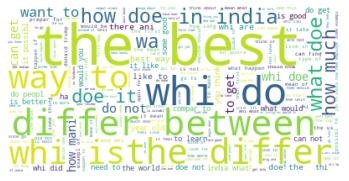

In [22]:
wc = WordCloud(background_color="white", max_words=len(text_nw),stopwords=stop_words)
# generate word cloud
wc.generate(text_nw)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h3> 3.5.1.2 plotting additional features </h3>

RATIO PLOT


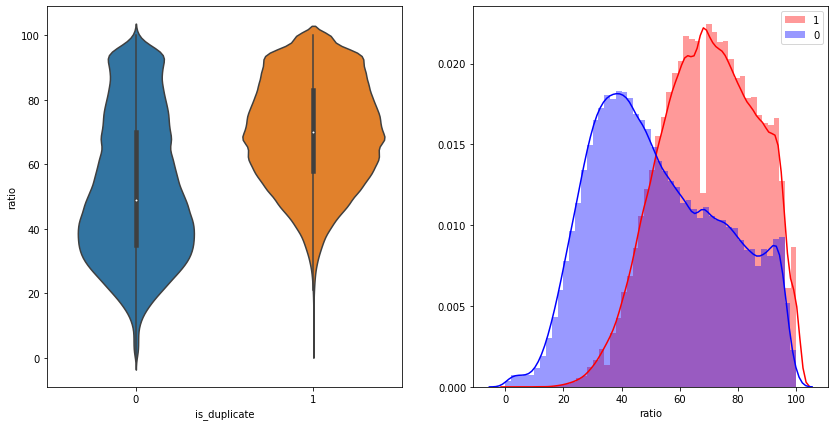

In [32]:
plt.figure(figsize=(14, 7))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['ratio'], label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['ratio'], label = "0" , color = 'blue' )
plt.legend()
plt.show()

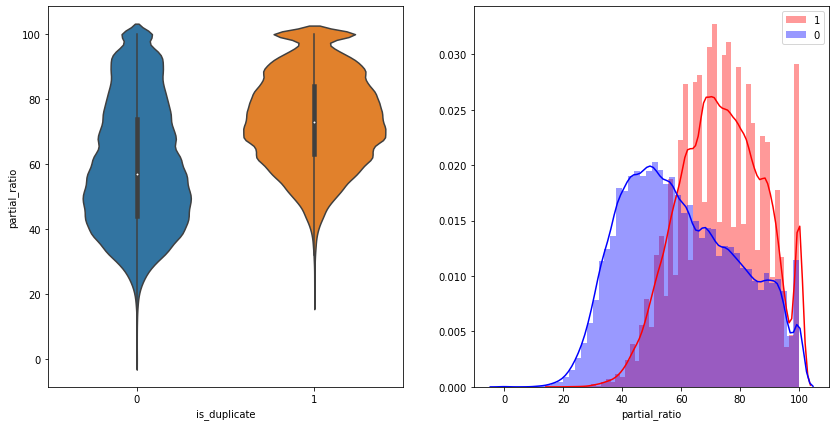

In [35]:
plt.figure(figsize=(14, 7))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'partial_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['partial_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['partial_ratio'][0:] , label = "0" , color = 'blue' )
plt.legend()
plt.show()

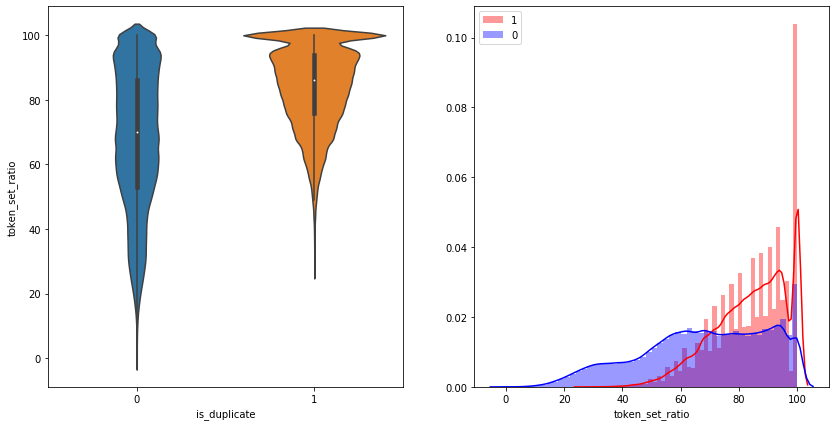

In [36]:
plt.figure(figsize=(14, 7))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_set_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_set_ratio'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_set_ratio'] , label = "0" , color = 'blue' )
plt.legend()
plt.show()

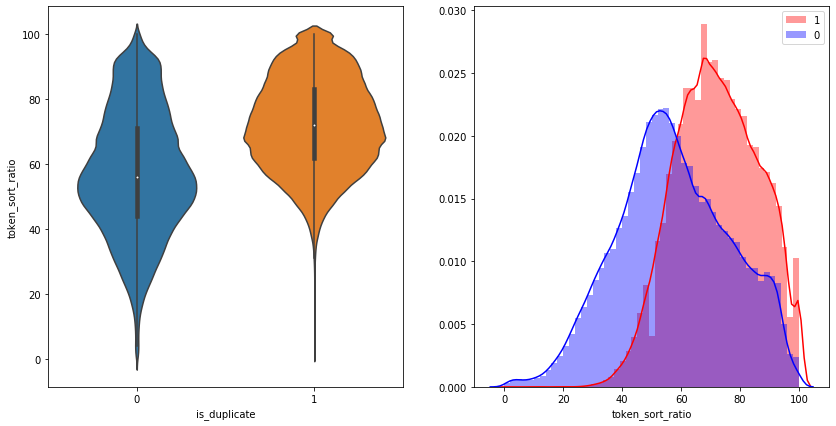

In [37]:
plt.figure(figsize=(14, 7))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'] , label = "0" , color = 'blue' )
plt.legend()
plt.show()

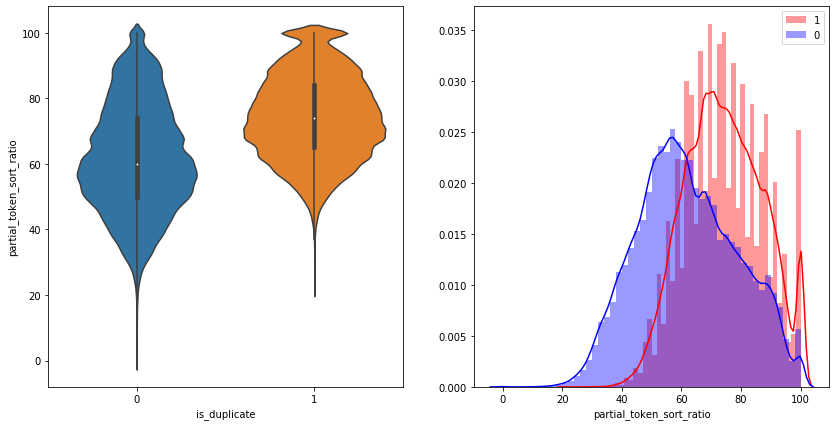

In [38]:
plt.figure(figsize=(14, 7))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'partial_token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['partial_token_sort_ratio'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['partial_token_sort_ratio'] , label = "0" , color = 'blue' )
plt.legend()
plt.show()

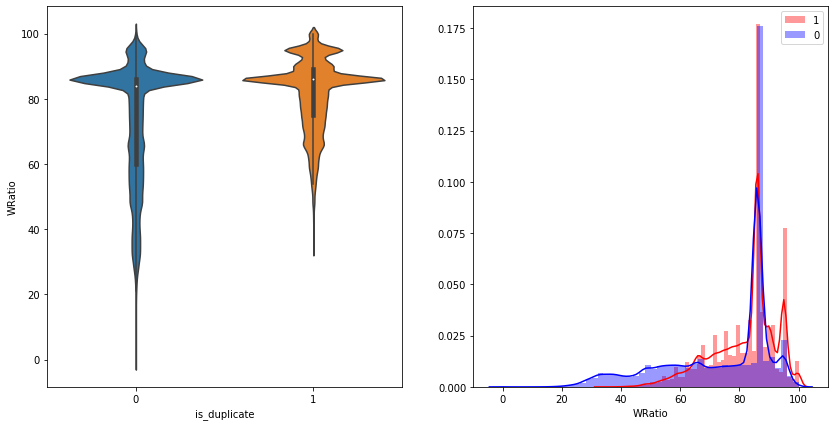

In [45]:
plt.figure(figsize=(14, 7))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'WRatio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['WRatio'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['WRatio'] , label = "0" , color = 'blue' )
plt.legend()
plt.show()

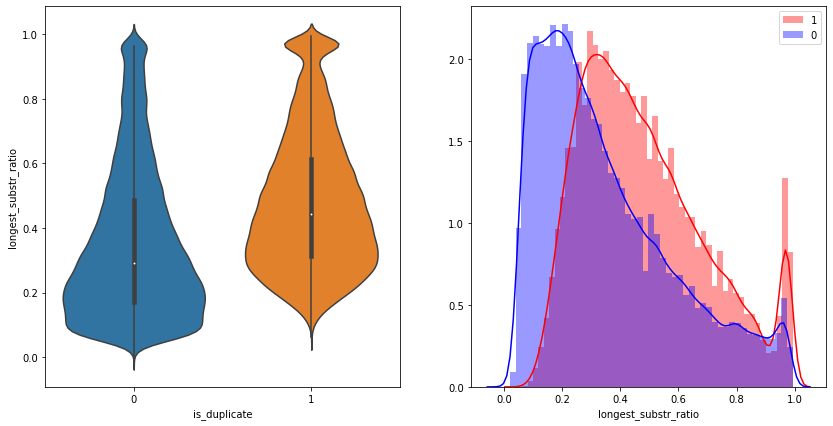

In [46]:
plt.figure(figsize=(14, 7))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'longest_substr_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['longest_substr_ratio'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['longest_substr_ratio'] , label = "0" , color = 'blue' )
plt.legend()
plt.show()

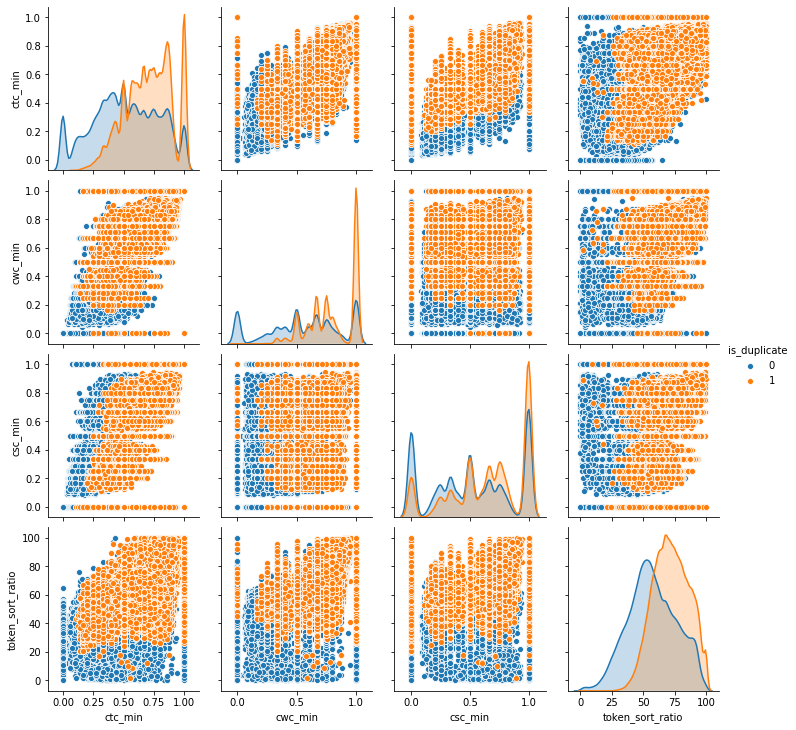

In [47]:

sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

<h3>3.5.2 Visualization </h3>

In [5]:
# Using TSNE for Dimentionality reduction for Features(Generated after cleaning the data) to 2 dimention
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
dfv_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfv_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'partial_token_set_ratio' , 'partial_token_sort_ratio','token_set_ratio' , 'token_sort_ratio' ,  'ratio' , 'partial_ratio' , 'longest_substr_ratio']])
y = dfv_subsampled['is_duplicate'].values

In [6]:
from sklearn.manifold import TSNE

In [7]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.015s...
[t-SNE] Computed neighbors for 5000 samples in 0.420s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.132654
[t-SNE] Computed conditional probabilities in 0.230s
[t-SNE] Iteration 50: error = 81.8030624, gradient norm = 0.0415018 (50 iterations in 3.029s)
[t-SNE] Iteration 100: error = 70.7305527, gradient norm = 0.0125631 (50 iterations in 1.993s)
[t-SNE] Iteration 150: error = 68.7745514, gradient norm = 0.0060700 (50 iterations in 1.862s)
[t-SNE] Iteration 200: error = 67.9423065, gradient norm = 0.0039164 (50 iterations in 1.799s)
[t-SNE] Iteration 250: error = 67.4272385, gradient norm = 0.0034600

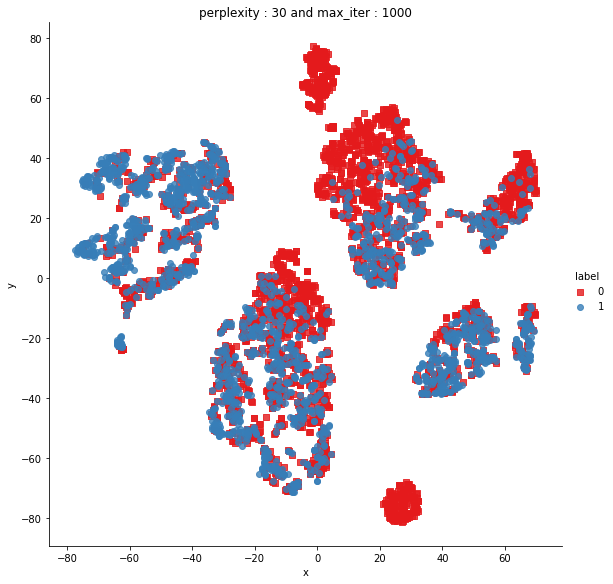

In [12]:
dfv = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=dfv, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [13]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 0.329s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.132654
[t-SNE] Computed conditional probabilities in 0.170s
[t-SNE] Iteration 50: error = 80.4209213, gradient norm = 0.0323624 (50 iterations in 7.758s)
[t-SNE] Iteration 100: error = 69.2953644, gradient norm = 0.0036677 (50 iterations in 4.140s)
[t-SNE] Iteration 150: error = 67.8730927, gradient norm = 0.0018555 (50 iterations in 3.946s)
[t-SNE] Iteration 200: error = 67.2965317, gradient norm = 0.0013796 (50 iterations in 3.569s)
[t-SNE] Iteration 250: error = 66.9634323, gradient norm = 0.0009161

In [17]:
import plotly.graph_objs as go
import plotly.offline as py

In [27]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.plot(fig, filename='3DBubble',auto_open = True)

'3DBubble.html'

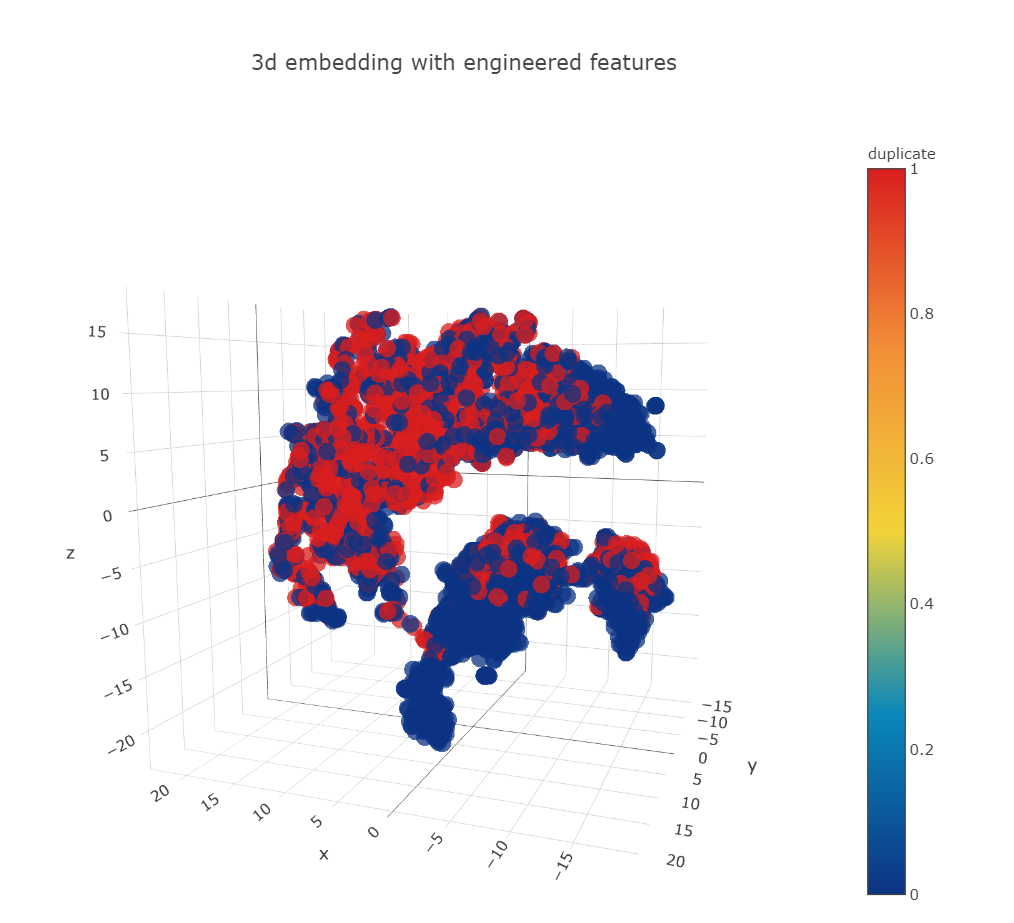

In [34]:
#photo of the above plotly
from IPython.display import Image
Image(filename=r"C:\Users\91984\OneDrive\Pictures\quora_3d.PNG")

<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [39]:
#using str(x) so that they can be encodede into utf-8 directly in python3
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [40]:
# merge texts
questions = list(df['question1']) + list(df['question2'])

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)



<808580x65721 sparse matrix of type '<class 'numpy.float64'>'
	with 8154105 stored elements in Compressed Sparse Row format>

In [48]:
# dict key:word,value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [91]:
word2tfidf

{'00': 10.196316891245568,
 '000': 11.46754192258067,
 '0001': 13.909888957949875,
 '0002': 13.909888957949875,
 '000k1': 13.909888957949875,
 '000k74': 13.909888957949875,
 '000s': 13.909888957949875,
 '000webhost': 13.50442384984171,
 '001': 12.811276669281765,
 '0015': 13.909888957949875,
 '0019': 12.99359822607572,
 '002': 13.21674177738993,
 '0021': 13.909888957949875,
 '0035': 13.909888957949875,
 '003sc': 13.909888957949875,
 '005': 13.909888957949875,
 '0051': 13.50442384984171,
 '007': 13.50442384984171,
 '008': 13.50442384984171,
 '008801703772104': 13.909888957949875,
 '0088882578743': 13.909888957949875,
 '00am': 11.963978808894563,
 '00g': 13.909888957949875,
 '00ghz': 13.909888957949875,
 '00k': 11.83044741627004,
 '00k21210': 13.909888957949875,
 '00m': 13.909888957949875,
 '00pm': 13.50442384984171,
 '00s': 13.909888957949875,
 '00v': 13.909888957949875,
 '01': 10.59570295327735,
 '0113': 13.909888957949875,
 '012': 13.21674177738993,
 '013j': 13.909888957949875,
 '014'

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [75]:
import spacy
from tqdm import tqdm

In [109]:
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for ques1 in tqdm(list(df['question1'])):
    doc1 = nlp(ques1) 
    mean_vec1 = np.zeros([1, len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1/len(doc1)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


100%|█████████████████████████████████████████████████████████████████████████| 404290/404290 [37:09<00:00, 181.34it/s]


In [110]:
vecs2 = []
for ques2 in tqdm(list(df['question2'])):
    doc2 = nlp(ques2) 
    mean_vec2 = np.zeros([1, len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2/len(doc2)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|███████████████████████████████████████████████████████████████████████| 404290/404290 [25:36:24<00:00,  4.39it/s]


In [124]:
df.q2_feats_m

0         [[3.875685542821884, 1.563473140199979, 1.4973...
1         [[-0.9719370362659295, 0.3610860089461009, 0.8...
2         [[5.506783940643072, 0.09770350158214569, 1.86...
3         [[2.5036007853654714, 3.757416796225768, 2.303...
4         [[2.034342410308974, 3.974573654787881, -0.225...
                                ...                        
404285    [[1.9117311262167418, 2.5329644897809396, 1.31...
404286    [[0.613170062088304, -0.3610845357179642, -0.9...
404287    [[3.0302095925435424, 1.40576833486557, 0.5971...
404288    [[5.077858448922634, 3.070593523979187, -0.051...
404289    [[1.8822683155536652, 1.8884442567825317, -0.9...
Name: q2_feats_m, Length: 404290, dtype: object

In [128]:
df_q2 = pd.DataFrame(df.q2_feats_m, index= df.index)

In [143]:
df['q2_feats_m'][0]

array([[ 3.87568554,  1.56347314,  1.49738443, -1.17452648, -0.31802906,
         1.58257256, -0.61930599,  0.40381307,  2.04141224, -2.5063172 ,
        -1.67600831, -0.69240664, -0.61775988, -1.82113888,  0.46684729,
         3.5267874 ,  1.63641304,  0.98565729, -0.18901372, -0.62927351,
         0.95515649,  0.9493326 ,  0.27481391, -0.03322489, -2.98620147,
         0.26545381, -1.00259933,  0.59461725, -1.73264088,  1.72429519,
        -4.08341176, -1.97366328, -0.36589882, -1.4549465 ,  1.10502711,
        -0.24721438,  1.16525267, -2.65859906,  1.19758502,  2.75643543,
         0.85033142, -2.74079943, -1.29621127,  3.10763032, -1.99290585,
        -1.10967637,  1.29698671,  3.02135067,  1.40738762,  0.95133551,
         1.39172885,  1.25119564,  0.90432436,  1.279727  , -0.52268759,
        -1.83144732,  0.66812921, -0.82131945,  2.18786314, -0.29587013,
        -2.63743558, -0.85850944, -0.392639  , -0.30217602, -1.21513985,
        -2.07507594, -0.35030138,  0.97736608,  0.0

In [163]:
final = []
for i in df['q1_feats_m']:
    for j in i:
        final.append(j)
#print(final)
dfq1=pd.DataFrame(final)
dfq1.head(5)

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,3.951004,1.410942,1.605049,-1.366279,0.190200,1.732589,-0.901595,0.153372,2.590892,-2.496524,...,-1.304194,-1.786549,-1.682513,-1.024770,-0.500115,-0.354826,0.190478,-0.330858,-0.115589,-0.002751
1,0.764606,2.711324,2.842477,0.708550,-0.902441,-0.951899,-4.631915,1.847286,1.439650,-2.724783,...,-1.503566,-0.142726,-5.632601,-3.289537,-1.393746,2.561927,1.766771,-3.855882,2.052214,-2.856266
2,1.909315,0.340026,0.152868,-0.538217,0.190008,0.646801,-0.895308,-0.629339,0.499306,-2.611245,...,-0.323527,-0.105370,-1.387731,-1.081641,0.681665,-0.285016,-0.164582,0.834412,-0.806626,-0.858899
3,-1.239291,0.242808,0.176479,-0.128119,-2.227218,2.237064,-1.652292,-0.086070,1.459814,-0.471650,...,-1.018095,0.024041,-1.952172,-1.151949,-1.221727,0.831442,0.506181,-2.052868,1.921479,-2.928604
4,8.336670,5.789392,-0.244993,-1.192348,-1.865202,1.300463,-4.384821,3.522171,0.467094,1.738089,...,-2.874439,-2.731144,-4.888827,-2.781493,-4.319351,0.575767,3.521489,-5.204085,1.898784,-1.773979


In [162]:

final = []
for i in df['q2_feats_m']:
    for j in i:
        final.append(j)
#print(final)
dfq2=pd.DataFrame(final)
dfq2.head(5)

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,3.875686,1.563473,1.497384,-1.174526,-0.318029,1.582573,-0.619306,0.403813,2.041412,-2.506317,...,-1.472576,-2.177186,-1.616655,-1.068673,-0.344378,-0.782341,-0.733758,-0.460292,-0.159334,-0.471633
1,-0.971937,0.361086,0.898938,0.761563,-1.240945,-0.096222,-2.414368,0.399766,1.738611,-1.632493,...,-3.051643,-0.525353,-3.750154,-1.660698,-1.517500,0.263868,-0.529114,-2.054628,1.571287,-2.837189
2,5.506784,0.097704,1.866548,-1.618267,-1.073139,0.826946,-0.859372,-0.617059,3.752909,-2.819528,...,-4.108214,-1.501123,-0.954417,-1.200248,-0.328863,0.571756,-0.152412,-1.363680,-2.022502,-0.242480
3,2.503601,3.757417,2.303359,-1.690352,-0.816411,-2.025224,-2.443798,-0.172717,2.560282,-2.057118,...,-2.577201,-2.224301,-2.258035,-1.120747,-1.825440,0.139813,-0.528936,-2.145596,-1.885260,0.966553
4,2.034342,3.974574,-0.225431,-0.785161,-1.849440,3.817149,-1.203126,3.772537,0.084943,-2.015685,...,-1.183139,-2.931559,-2.126067,-2.440991,-3.213496,-0.690513,-1.671410,2.087246,0.448572,-1.340031


In [ ]:
df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))

In [ ]:
df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["partial_token_sort_ratio"]   = df.apply(lambda x: fuzz.partial_token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["partial_token_set_ratio"]    = df.apply(lambda x: fuzz.partial_token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["WRatio"]    = df.apply(lambda x: fuzz.WRatio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)

In [165]:
df1 = df[["id","is_duplicate","cwc_min","cwc_max","csc_min","csc_max","ctc_min","ctc_max","last_word_eq","first_word_eq","abs_len_diff","mean_len","token_set_ratio","token_sort_ratio","ratio","partial_ratio","partial_token_sort_ratio","partial_token_set_ratio","WRatio","longest_substr_ratio"]]
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,ratio,partial_ratio,partial_token_sort_ratio,partial_token_set_ratio,WRatio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,92,92,100,87,100,95,0.982143
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,65,67,71,73,100,86,0.571429
2,2,0,0.599988,0.499992,0.399992,0.249997,0.499995,0.357140,0.0,1.0,4.0,12.0,72,64,39,38,70,100,68,0.185185
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,31,27,22,27,33,36,29,0.045455
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,68,50,36,54,72,100,86,0.157895


In [166]:
df2 = df[["id","freq_q1","freq_q2","len_q1","len_q2","words_q1","words_q2","common_words","total_words","share_words","sum_freq","diff_freq"]]
df2.head()

,id,freq_q1,freq_q2,len_q1,len_q2,words_q1,words_q2,common_words,total_words,share_words,sum_freq,diff_freq
0,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,4,1,51,88,8,13,4,20,0.200000,5,3
2,2,1,1,73,59,14,10,4,24,0.166667,2,0
3,3,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,3,1,76,39,13,7,2,20,0.100000,4,2


In [170]:
dfq1["id"]=df["id"]

In [171]:
dfq1

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,id
0,3.951004,1.410942,1.605049,-1.366279,0.190200,1.732589,-0.901595,0.153372,2.590892,-2.496524,...,-1.786549,-1.682513,-1.024770,-0.500115,-0.354826,0.190478,-0.330858,-0.115589,-0.002751,0
1,0.764606,2.711324,2.842477,0.708550,-0.902441,-0.951899,-4.631915,1.847286,1.439650,-2.724783,...,-0.142726,-5.632601,-3.289537,-1.393746,2.561927,1.766771,-3.855882,2.052214,-2.856266,1
2,1.909315,0.340026,0.152868,-0.538217,0.190008,0.646801,-0.895308,-0.629339,0.499306,-2.611245,...,-0.105370,-1.387731,-1.081641,0.681665,-0.285016,-0.164582,0.834412,-0.806626,-0.858899,2
3,-1.239291,0.242808,0.176479,-0.128119,-2.227218,2.237064,-1.652292,-0.086070,1.459814,-0.471650,...,0.024041,-1.952172,-1.151949,-1.221727,0.831442,0.506181,-2.052868,1.921479,-2.928604,3
4,8.336670,5.789392,-0.244993,-1.192348,-1.865202,1.300463,-4.384821,3.522171,0.467094,1.738089,...,-2.731144,-4.888827,-2.781493,-4.319351,0.575767,3.521489,-5.204085,1.898784,-1.773979,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,1.862852,2.009007,1.325547,-0.713333,-0.535156,1.513328,-3.164300,3.637514,1.562143,-2.666049,...,-1.614362,-2.610651,0.036322,-1.570762,1.778846,1.404897,0.489229,-0.144265,-1.831977,404285
404286,2.994922,0.821478,0.410133,0.965356,-0.896263,0.095410,-1.363722,-1.257058,-0.180143,-2.180645,...,-2.174666,-1.150782,-1.404598,0.796096,2.194859,-0.494274,1.689111,-1.910322,-3.159822,404286
404287,2.175033,1.853683,3.249868,-0.492138,0.739605,-0.742709,-3.253703,-0.913367,-0.340568,-3.107726,...,-1.212025,-1.240280,-2.850802,-1.478699,-0.636967,-0.370155,0.928731,-2.382163,1.312906,404287
404288,3.222239,0.285342,2.821031,-0.833190,-0.500030,-1.228673,-3.187055,1.973233,3.155603,-4.234711,...,-1.737325,-2.145571,-0.842153,-0.534776,0.341542,2.401294,0.458718,0.968140,-1.540283,404288


In [172]:
dfq2["id"]=df["id"]

In [173]:
dfq2

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,id
0,3.875686,1.563473,1.497384,-1.174526,-0.318029,1.582573,-0.619306,0.403813,2.041412,-2.506317,...,-2.177186,-1.616655,-1.068673,-0.344378,-0.782341,-0.733758,-0.460292,-0.159334,-0.471633,0
1,-0.971937,0.361086,0.898938,0.761563,-1.240945,-0.096222,-2.414368,0.399766,1.738611,-1.632493,...,-0.525353,-3.750154,-1.660698,-1.517500,0.263868,-0.529114,-2.054628,1.571287,-2.837189,1
2,5.506784,0.097704,1.866548,-1.618267,-1.073139,0.826946,-0.859372,-0.617059,3.752909,-2.819528,...,-1.501123,-0.954417,-1.200248,-0.328863,0.571756,-0.152412,-1.363680,-2.022502,-0.242480,2
3,2.503601,3.757417,2.303359,-1.690352,-0.816411,-2.025224,-2.443798,-0.172717,2.560282,-2.057118,...,-2.224301,-2.258035,-1.120747,-1.825440,0.139813,-0.528936,-2.145596,-1.885260,0.966553,3
4,2.034342,3.974574,-0.225431,-0.785161,-1.849440,3.817149,-1.203126,3.772537,0.084943,-2.015685,...,-2.931559,-2.126067,-2.440991,-3.213496,-0.690513,-1.671410,2.087246,0.448572,-1.340031,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,1.911731,2.532964,1.310267,-1.091523,-0.657372,0.587566,-2.336213,4.910746,2.579544,-3.122174,...,-1.914445,-2.039175,0.368558,-2.227197,1.661271,1.611826,0.847272,-0.782276,-1.188200,404285
404286,0.613170,-0.361085,-0.995831,0.280419,0.323467,0.892614,-1.192465,-2.695308,-0.599138,-2.847159,...,-2.321449,-0.510999,-1.081627,-0.011589,1.268735,0.913431,0.943295,-0.600541,-2.807023,404286
404287,3.030210,1.405768,0.597103,-0.340709,1.542163,-2.522696,-2.946566,0.106681,-0.380231,-3.098670,...,-0.287876,1.137516,-1.829732,-0.435015,-2.458959,-0.841972,1.448776,-3.408199,-0.485755,404287
404288,5.077858,3.070594,-0.051362,-0.228020,-0.652117,1.189081,0.399125,0.803429,-0.651846,-0.184722,...,-1.081512,-3.400102,-1.721905,-1.135527,0.348373,-1.242748,0.990686,0.783996,-0.840947,404288


In [174]:
print("Number of features in nlp dataframe :", df1.shape[1]-2)
print("Number of features in preprocessed dataframe :", df2.shape[1]-1)
print("Number of features in question1 w2v  dataframe :", dfq1.shape[1]-1)
print("Number of features in question2 w2v  dataframe :", dfq2.shape[1]-1)
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+dfq1.shape[1]+dfq2.shape[1]-5)

Number of features in nlp dataframe : 18
Number of features in preprocessed dataframe : 11
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 221


In [175]:
dfq1n2  = dfq1.merge(dfq2, on='id',how='left')
dfq1n2.head()

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,3.951004,1.410942,1.605049,-1.366279,0.190200,1.732589,-0.901595,0.153372,2.590892,-2.496524,...,-1.472576,-2.177186,-1.616655,-1.068673,-0.344378,-0.782341,-0.733758,-0.460292,-0.159334,-0.471633
1,0.764606,2.711324,2.842477,0.708550,-0.902441,-0.951899,-4.631915,1.847286,1.439650,-2.724783,...,-3.051643,-0.525353,-3.750154,-1.660698,-1.517500,0.263868,-0.529114,-2.054628,1.571287,-2.837189
2,1.909315,0.340026,0.152868,-0.538217,0.190008,0.646801,-0.895308,-0.629339,0.499306,-2.611245,...,-4.108214,-1.501123,-0.954417,-1.200248,-0.328863,0.571756,-0.152412,-1.363680,-2.022502,-0.242480
3,-1.239291,0.242808,0.176479,-0.128119,-2.227218,2.237064,-1.652292,-0.086070,1.459814,-0.471650,...,-2.577201,-2.224301,-2.258035,-1.120747,-1.825440,0.139813,-0.528936,-2.145596,-1.885260,0.966553
4,8.336670,5.789392,-0.244993,-1.192348,-1.865202,1.300463,-4.384821,3.522171,0.467094,1.738089,...,-1.183139,-2.931559,-2.126067,-2.440991,-3.213496,-0.690513,-1.671410,2.087246,0.448572,-1.340031


In [176]:
result  = df.merge(dfq1n2, on='id',how='left')

In [177]:
result.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_q1,freq_q2,len_q1,len_q2,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,1,1,66,57,...,-1.472576,-2.177186,-1.616655,-1.068673,-0.344378,-0.782341,-0.733758,-0.460292,-0.159334,-0.471633
1,1,3,4,what is the stori of kohinoor koh i noor diamond,what would happen if the indian govern stole t...,0,4,1,51,88,...,-3.051643,-0.525353,-3.750154,-1.660698,-1.517500,0.263868,-0.529114,-2.054628,1.571287,-2.837189
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0,1,1,73,59,...,-4.108214,-1.501123,-0.954417,-1.200248,-0.328863,0.571756,-0.152412,-1.363680,-2.022502,-0.242480
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math 23 24 math is divid...,0,1,1,50,65,...,-2.577201,-2.224301,-2.258035,-1.120747,-1.825440,0.139813,-0.528936,-2.145596,-1.885260,0.966553
4,4,9,10,which one dissolv in water quik sugar salt met...,which fish would surviv in salt water,0,3,1,76,39,...,-1.183139,-2.931559,-2.126067,-2.440991,-3.213496,-0.690513,-1.671410,2.087246,0.448572,-1.340031


In [179]:
result.drop(["q1_feats_m","q2_feats_m"],axis=1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_q1,freq_q2,len_q1,len_q2,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,1,1,66,57,...,-1.472576,-2.177186,-1.616655,-1.068673,-0.344378,-0.782341,-0.733758,-0.460292,-0.159334,-0.471633
1,1,3,4,what is the stori of kohinoor koh i noor diamond,what would happen if the indian govern stole t...,0,4,1,51,88,...,-3.051643,-0.525353,-3.750154,-1.660698,-1.517500,0.263868,-0.529114,-2.054628,1.571287,-2.837189
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0,1,1,73,59,...,-4.108214,-1.501123,-0.954417,-1.200248,-0.328863,0.571756,-0.152412,-1.363680,-2.022502,-0.242480
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math 23 24 math is divid...,0,1,1,50,65,...,-2.577201,-2.224301,-2.258035,-1.120747,-1.825440,0.139813,-0.528936,-2.145596,-1.885260,0.966553
4,4,9,10,which one dissolv in water quik sugar salt met...,which fish would surviv in salt water,0,3,1,76,39,...,-1.183139,-2.931559,-2.126067,-2.440991,-3.213496,-0.690513,-1.671410,2.087246,0.448572,-1.340031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,how mani keyword are there in the racket progr...,how mani keyword are there in perl program lan...,0,2,2,85,79,...,-2.738181,-1.914445,-2.039175,0.368558,-2.227197,1.661271,1.611826,0.847272,-0.782276,-1.188200
404286,404286,18840,155606,do you believ there is life after death,is it true that there is life after death,1,12,1,41,42,...,-1.413401,-2.321449,-0.510999,-1.081627,-0.011589,1.268735,0.913431,0.943295,-0.600541,-2.807023
404287,404287,537928,537929,what is one coin,what is this coin,0,1,1,17,17,...,3.407263,-0.287876,1.137516,-1.829732,-0.435015,-2.458959,-0.841972,1.448776,-3.408199,-0.485755
404288,404288,537930,537931,what is the approx annual cost of live while s...,i am have littl hairfal problem but i want to ...,0,1,1,94,127,...,-2.329542,-1.081512,-3.400102,-1.721905,-1.135527,0.348373,-1.242748,0.990686,0.783996,-0.840947


In [180]:
result.to_csv('quorafinal_features.csv')

In [4]:
result=pd.read_csv((r"C:\Users\91984\Downloads\quorafinal_features.csv"))

In [5]:
for i in result.columns:
    print(i)

Unnamed: 0
id
qid1
qid2
question1
question2
is_duplicate
freq_q1
freq_q2
len_q1
len_q2
words_q1
words_q2
common_words
total_words
share_words
sum_freq
diff_freq
cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
ratio
partial_ratio
partial_token_sort_ratio
partial_token_set_ratio
WRatio
longest_substr_ratio
q1_feats_m
q2_feats_m
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y


In [6]:
result.drop(['Unnamed: 0','id','qid1','qid2','question1','question2'], axis=1, inplace=True)

In [7]:
y_true = result['is_duplicate']
result.drop(['is_duplicate'], axis=1, inplace=True)

In [8]:
result.drop(['q1_feats_m','q2_feats_m'], axis=1, inplace=True)

<h2> 4.Building ML models </h2>

<h2> 4.1 Splitting the data into train and test </h2>

In [9]:
from sklearn.model_selection import train_test_split

In [10]:

X_train,X_test, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.3)
#we use stratify so that we get an even distribution among train and test data 

In [11]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 221)
Number of data points in test data : (121287, 221)


In [12]:
from collections import Counter

In [13]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in train data ----------
Class 0:  0.6308013224830361 Class 1:  0.3691986775169639


In [14]:
from sklearn.metrics import confusion_matrix

In [15]:
# This function plots the confusion matrices given y_i, y_i_hat.
# precision matrix specifies percentage of each element of confusion matrix among the predicted class
# recall matrix specifies percentage of each element of confusion matrix among the original class
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2>4.2 Building a random model to find worst-case log-loss</h2>

In [16]:
from sklearn.metrics.classification import accuracy_score, log_loss

Log loss on Test Data using Random Model 0.8903878904523007


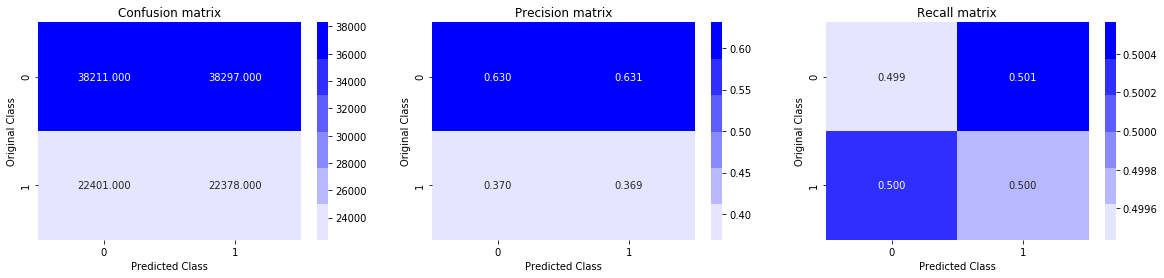

In [17]:
# we need to generate 2 numbers and the sum of numbers should be 1
# one solution is to genarate 2 numbers and divide each of the numbers by their sum
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.3 Logistic Regression with hyperparameter tuning </h2>

In [18]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
#https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/

In [19]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)




log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 0.43298363760405006
For values of alpha =  0.0001 The log loss is: 0.43220895584219715
For values of alpha =  0.001 The log loss is: 0.42632280576140014
For values of alpha =  0.01 The log loss is: 0.4240943914743827
For values of alpha =  0.1 The log loss is: 0.43153196734789134
For values of alpha =  1 The log loss is: 0.46330126160456325
For values of alpha =  10 The log loss is: 0.507956146156608


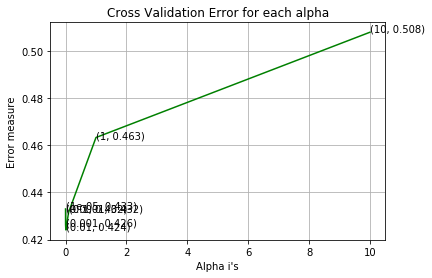

For values of best alpha =  0.01 The train log loss is: 0.4261075481086578
For values of best alpha =  0.01 The test log loss is: 0.4240943914743827
Total number of data points : 121287


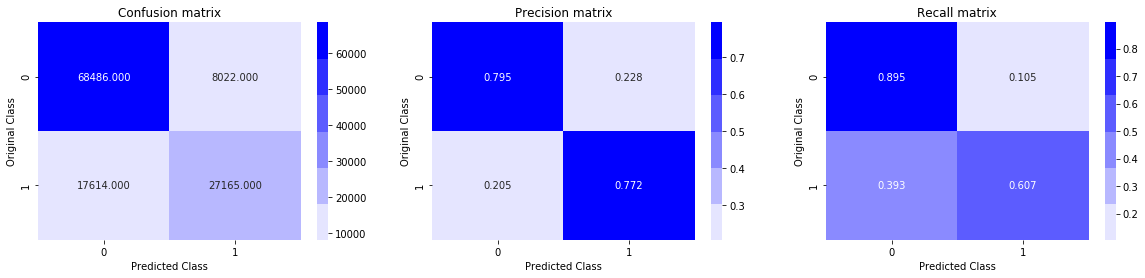

In [20]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(log_error_array):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],np.round(txt,3)))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4550943034174212
For values of alpha =  0.0001 The log loss is: 0.47953454378394883
For values of alpha =  0.001 The log loss is: 0.4895779394355543
For values of alpha =  0.01 The log loss is: 0.5035268061533587
For values of alpha =  0.1 The log loss is: 0.5094240294375398
For values of alpha =  1 The log loss is: 0.5803303415021279
For values of alpha =  10 The log loss is: 0.6391190903216616


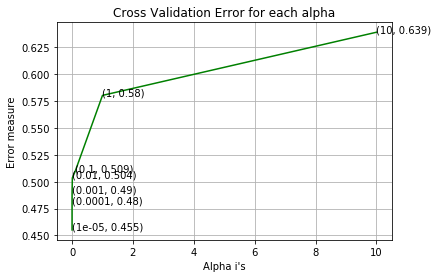

For values of best alpha =  1e-05 The train log loss is: 0.45722324398018027
For values of best alpha =  1e-05 The test log loss is: 0.4550943034174212
Total number of data points : 121287


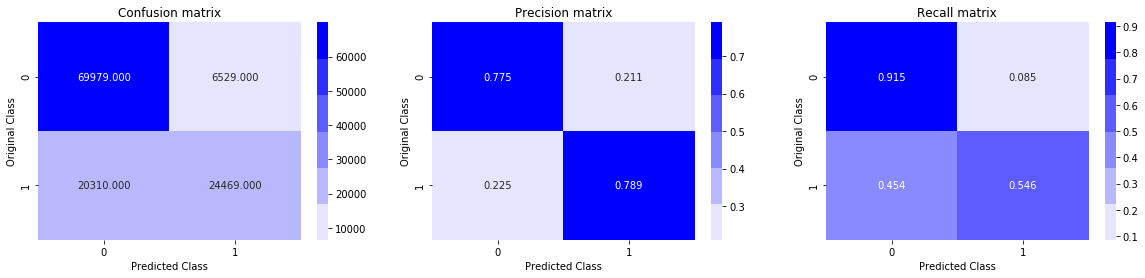

In [21]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.




log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [22]:

from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

In [23]:
x_cfl=XGBClassifier(objective='binary:logistic',eval_metric = "logloss",njobs=1)

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,n_iter=12)
random_cfl.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 69.9min
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed: 177.1min remaining: 77.9min
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed: 281.0min remaining: 67.8min
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed: 302.6min remaining: 27.5min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 455.8min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       njobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=12, n_jobs=-1,
          param_distributions={'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2], 'n_estimators': [100, 200, 500, 1000], 'max_depth': [3, 5, 10], 'colsample_bytree': [0.1, 0.3, 0.5, 1], 'subsample': [0.1, 0.3, 0.5, 1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=10)

In [24]:
print(random_cfl.best_params_)

{'subsample': 1, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1}


In [26]:
x_cfl=XGBClassifier(n_estimators=100,max_depth=10,learning_rate=0.1,subsample= 1,colsample_bytree= 1,objective='binary:logistic',eval_metric = "logloss",nthread=-1)
x_cfl.fit(X_train,y_train,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ( "The train log loss is:",log_loss(y_train, predict_y))

predict_y = sig_clf.predict_proba(X_test)
print( "The test log loss is:",log_loss(y_test, predict_y))

The train log loss is: 0.2285782882738265
The test log loss is: 0.33167239318638947


In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
#selecting the most important features
rf_clf=RandomForestClassifier(n_estimators=500,random_state=42,n_jobs=-1, class_weight='balanced')
rf_clf.fit(X_train ,y_train)    

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [48]:
feature_index = np.argsort(rf_clf.feature_importances_)[::-1]
most_imp_feat_idx=feature_index[:100]

In [49]:
most_imp_feat_idx

array([  1,   8,   9,  12,   0,  11,  23,  24,  16,   6,  22,  21,  17,
        25,  28,  15,  14,  10,  27,  13,  20,   3,  19,   2,   7, 121,
        53, 104,  94, 200, 217,  78,  73,   5,  92, 190,  71,  58, 149,
       122,  35,  63,  84,  90, 154,  30, 159,  65,   4, 161,  89, 188,
       119, 212, 174,  31, 116, 163, 219, 218, 169,  79,  80,  33, 175,
        66, 127,  67, 215, 123, 111, 211, 131,  97, 193,  95, 110, 150,
       183, 126, 162,  54,  38,  62, 204, 134,  46, 115, 220, 176, 108,
       117, 167, 129, 191, 180, 132, 100,  51, 186], dtype=int64)

In [50]:
X_train=np.array(X_train)
X_test=np.array(X_test)

In [51]:
X_train_imp=X_train[:,list(most_imp_feat_idx)]
X_test_imp=X_test[:,list(most_imp_feat_idx)]

In [52]:
x_cfl=XGBClassifier(objective='binary:logistic',eval_metric = "logloss",njobs=1)

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,n_iter=12)
random_cfl.fit(X_train_imp, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 65.2min
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed: 75.8min remaining: 33.4min
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed: 81.2min remaining: 19.6min
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed: 88.7min remaining:  8.1min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 89.6min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       njobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=12, n_jobs=-1,
          param_distributions={'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2], 'n_estimators': [100, 200, 500, 1000], 'max_depth': [3, 5, 10], 'colsample_bytree': [0.1, 0.3, 0.5, 1], 'subsample': [0.1, 0.3, 0.5, 1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=10)

In [53]:
print(random_cfl.best_params_)

{'subsample': 0.3, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 1}


In [54]:
x_cfl=XGBClassifier(n_estimators=200,max_depth=10,learning_rate=0.05,subsample= 0.3,colsample_bytree= 1,objective='binary:logistic',eval_metric = "logloss",nthread=-1)
x_cfl.fit(X_train_imp,y_train,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_imp, y_train)
    
predict_y = sig_clf.predict_proba(X_train_imp)
print ( "The train log loss is:",log_loss(y_train, predict_y))

predict_y = sig_clf.predict_proba(X_test_imp)
print( "The test log loss is:",log_loss(y_test, predict_y))

The train log loss is: 0.2624965920884131
The test log loss is: 0.33624831843908504


<h1> CONCLUSION: </h1>

<h2> steps taken: </h2>

- we first featurize basic features which will not require text precessing like freq of one question, length of question etc.
- after this we perform tet preprocessing, in that we perform stemming, then remove stopwords,tags,punctuations and expand contractions.
- we then make NLP features, by splitting the sentences into token, stop-words, non-stop words.
- we can make use of fuzzywuzzy package to make fuzzy features.
- Now we fit with the Randomforest classifier on data. Now we select the best features from the data based on feature importances of the features.</br>
- Now we will build our final XGBoost model using the selected features we have got . We perform the hyperparameter tuning on this data using the XGBoost classifier and get the optimum parameters. Now we build our final model using these parameters and check the logloss.</br>

In [56]:
from prettytable import PrettyTable

In [57]:
x = PrettyTable(['Model','train Logloss','test logloss'])
x.add_row(['Logistic Regression', 0.42, 0.42])
x.add_row(['Linear SVM',0.45, 0.45])
x.add_row(['XGBoost ',0.26, 0.33])
print(x)

+---------------------+---------------+--------------+
|        Model        | train Logloss | test logloss |
+---------------------+---------------+--------------+
| Logistic Regression |      0.42     |     0.42     |
|      Linear SVM     |      0.45     |     0.45     |
|       XGBoost       |      0.26     |     0.33     |
+---------------------+---------------+--------------+
